In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook analyzes how well the model in MAVE_trial.ipynb (and MAVE_trial.nbconvert.ipynb)
## learned the data by analyzing the pearson Rs for each cell between inputted raw data and 
## MAVE reconstructed output data
### The notebook also looks at stabilization of loss functions 
##loss_scalers = [10000, 1, 1, 10000]

%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(stringr)
library(tidyr)
library(ggpointdensity)

In [3]:
%%R
Loss <- read.csv('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/logs/training.log.2023-01-18_20044033.680598', sep ='\t')
colnames(Loss)[2] <- 'Total_Loss'
Loss$Recon_Loss <- str_sub(Loss$Recon_Loss, start = 8, end = 17)
Loss$KLD_Loss <- str_sub(Loss$KLD_Loss, start = 8, end = 13)
Loss$Classification_Loss <- str_sub(Loss$Classification_Loss, start = 8, end = 13)
Loss$Triplet_Loss <- str_sub(Loss$Triplet_Loss, start = 8, end = 13)
Loss[,3:6] <- apply(Loss[,3:6], 2, as.numeric)
Loss$Recon_Loss[which(is.na(Loss$Recon_Loss))] = Loss$Recon_Loss[which(is.na(Loss$Recon_Loss)) - 1]


Loss$Recon_Loss <- Loss$Recon_Loss/max(Loss$Recon_Loss)
Loss$KLD_Loss <- Loss$KLD_Loss/max(Loss$KLD_Loss)
Loss$Classification_Loss <- Loss$Classification_Loss/max(Loss$Classification_Loss)
Loss$Triplet_Loss <- Loss$Triplet_Loss/max(Loss$Triplet_Loss)


Individual_losses <- pivot_longer(Loss, cols = 3:6, names_to = 'Loss_type', values_to = 'Loss')


In addition: Warning message:
In apply(Loss[, 3:6], 2, as.numeric) : NAs introduced by coercion


In [4]:
%%R
Loss

     Epoch Total_Loss Recon_Loss   KLD_Loss Classification_Loss Triplet_Loss
1        0  13.223639  1.0000000 1.00000000           0.9931883    1.0000000
2        1   9.280825  0.9126676 0.24331361           0.9913852    0.9730920
3        2   8.734225  0.9071292 0.13887574           0.9879460    0.9530786
4        3   8.589245  0.8776583 0.10621302           0.9886305    0.9561429
5        4   8.533408  0.8837085 0.08739645           0.9880128    0.9641865
6        5   8.493685  0.8820859

 0.07899408           0.9874284    0.9579623
7        6   8.459766  0.8668008 0.06822485           0.9857255    0.9645696
8        7   8.428600  0.8568470 0.05887574           0.9835217    0.9497271
9        8   8.401894  0.8545573 0.05343195           0.9845568    0.9568132
10       9   8.378952  0.8718049 0.04650888           0.9789639    0.9567174
11      10   8.355837  0.8534259 0.04189349           0.9823864    0.9538447
12      11   8.333858  0.8561126 0.03674556           0.9818856    0.9641865
13      12   8.312922  0.8559003 0.03402367           0.9812511    0.9589199
14      13   8.287213  0.8229911 0.02857988           0.9816017    0.9545150
15      14   8.265120  0.8323644 0.02923077           0.9770773    0.9525041
16      15   8.253046  0.8449867 0.02343195           0.9739720    0.9549938
17      16   8.265111  0.8385829 0.02331361           0.9740555    0.9532701
18      17   8.241887  0.8418845 0.02183432           0.9752575    0.9547065
19      18   8.214315  0.848319

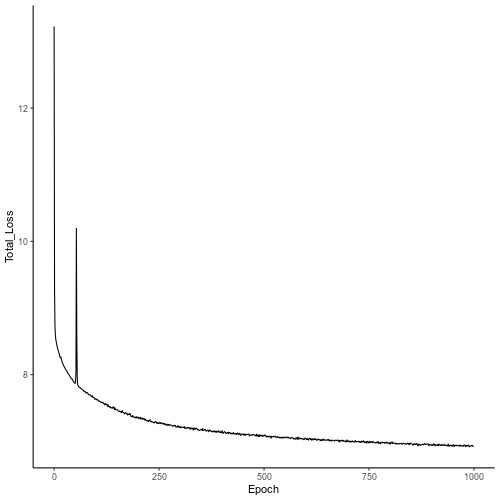

In [5]:
%%R -h 500 -w 500
Total_loss_plot <- ggplot(Loss, aes(Epoch, Total_Loss)) + geom_path() + theme_classic()
Total_loss_plot

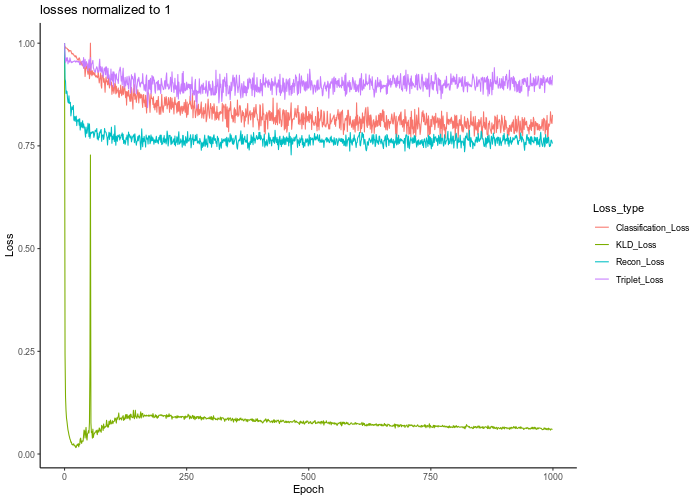

In [6]:
%%R -h 500 -w 700
Individual_loss_plot <- ggplot(Individual_losses, aes(Epoch, Loss, color = Loss_type)) + geom_path() + theme_classic() + ggtitle("losses normalized to 1")
Individual_loss_plot

In [7]:
%%R
Rs <- read.csv('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/R_tbl.csv')

epoch_1 = as.numeric(Rs[1,])
epoch_200 = as.numeric(Rs[200,])
epoch_500 = as.numeric(Rs[500,])
epoch_1000 = as.numeric(Rs[1000,])

df <- data.frame(epoch_1, epoch_200, epoch_500, epoch_1000)
df <- pivot_longer(df, cols = 1:4, names_to = 'Epoch', values_to = 'Rs')

In [8]:
%%R
head(df)

# A tibble: 6 × 2
  Epoch           Rs
  <chr>        <dbl>
1 epoch_1      0    
2 epoch_200  199    
3 epoch_500  499    
4 epoch_1000 999    
5 epoch_1      0.654
6 epoch_200    0.938


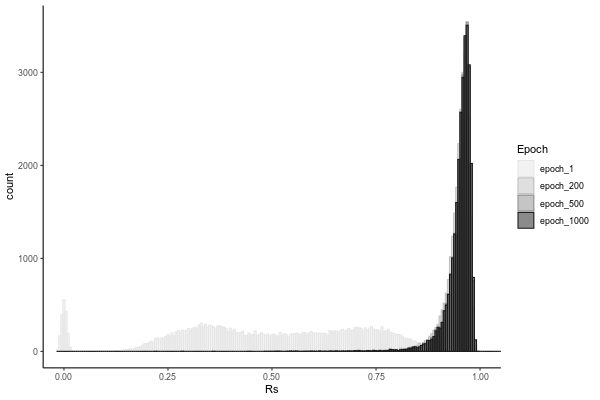

In [9]:
%%R -h 400 -w 600
df$Epoch <- factor(df$Epoch, levels = c('epoch_1', 'epoch_200', 'epoch_500', 'epoch_1000'))
R_learning <- ggplot(df, aes(x=Rs, fill=Epoch, color=Epoch)) +
geom_histogram(position="identity", alpha=0.5, bins = 200000) + scale_color_grey(start = 0.9, end = 0.1) +
scale_fill_grey(start = 0.9, end = 0.1) +
theme_classic() + coord_cartesian(xlim = c(0,1))
R_learning

In [10]:
%%R
medians <- matrixStats::rowMedians(as.matrix(Rs))
Loss$medians <- medians

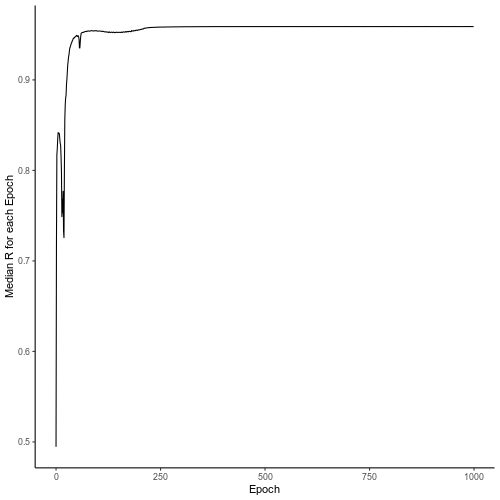

In [11]:
%%R -h 500 -w 500
R_median_plot <-ggplot(Loss, aes(Epoch, medians)) + geom_path() + ylab('Median R for each Epoch') + theme_classic()
R_median_plot

In [12]:
%%R
UMAP_output <- read.csv("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/UMAP-OF-MU.tsv.gz", sep = '\t', row.names = 1)
head(UMAP_output)

                             UMAP1    UMAP2           guide
miR_1:AAACCCAAGGAGAGGC-1 14.404250 3.687525 hsa-miR-203a-3p
miR_1:AAACCCAAGGTAAACT-1  7.894105 4.104230   hsa-miR-93-3p
miR_1:AAACCCACAACGATCT-1  7.399960 6.234716 hsa-miR-130b-3p
miR_1:AAACCCACACGATTCA-1  8.701717 7.155861          TuD_NC
miR_1:AAACCCACAGTCAACT-1  8.888281 2.977333 hsa-miR-147b-5p
miR_1:AAACCCACATCTCATT-1 10.654594 6.797928  hsa-miR-501-5p


In [13]:
%%R
library(dplyr)
MAVE_latent_2dims <- read.csv("/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/scMAVE_mu-matrix.tsv.gz", sep = '\t', row.names = 1)
MAVE_latent_2dims <- select(MAVE_latent_2dims, LV.mu.0, LV.mu.1)
MAVE_latent_2dims$guide <- UMAP_output$guide
head(MAVE_latent_2dims)

                              LV.mu.0      LV.mu.1           guide
miR_1:AAACCCAAGGAGAGGC-1 -0.067877077 -0.263472944 hsa-miR-203a-3p
miR_1:AAACCCAAGGTAAACT-1  0.055841550 -0.061134674   hsa-miR-93-3p
miR_1:AAACCCACAACGATCT-1 -0.039762489  0.128707662 hsa-miR-130b-3p
miR_1:AAACCCACACGATTCA-1 -0.009009097  0.012031920          TuD_NC
miR_1:AAACCCACAGTCAACT-1  0.025359716 -0.009894387 hsa-miR-147b-5p
miR_1:AAACCCACATCTCATT-1  0.074254528  0.009449955  hsa-miR-501-5p



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [14]:
%%R
guides = unique(MAVE_latent_2dims$guide)
tmp_df = as.data.frame(matrix(0, nrow = nrow(MAVE_latent_2dims), ncol = length(guides)))
colnames(tmp_df) = guides
for (i in 1:length(guides)){
    guide_cells = MAVE_latent_2dims$guide == guides[i]
    vec = MAVE_latent_2dims$guide
    vec[guide_cells] = 'Guide'
    vec[!guide_cells] = 'N/A'
    tmp_df[,i] <- vec
}
MAVE_latent_2dims = cbind(MAVE_latent_2dims, tmp_df)

In [15]:
%%R
guides = unique(UMAP_output$guide)
tmp_df = as.data.frame(matrix(0, nrow = nrow(UMAP_output), ncol = length(guides)))
colnames(tmp_df) = guides
for (i in 1:length(guides)){
    guide_cells = UMAP_output$guide == guides[i]
    vec = UMAP_output$guide
    vec[guide_cells] = 'Guide'
    vec[!guide_cells] = 'N/A'
    tmp_df[,i] <- vec
}
UMAP_output_2dims = cbind(UMAP_output, tmp_df)

In [16]:
%%R
print(paste(nrow(MAVE_latent_2dims), 'rows'))
print(paste(ncol(MAVE_latent_2dims), 'columns'))
head(MAVE_latent_2dims[, 1:5])

[1] "29147 rows"
[1] "380 columns"
                              LV.mu.0      LV.mu.1           guide
miR_1:AAACCCAAGGAGAGGC-1 -0.067877077 -0.263472944 hsa-miR-203a-3p
miR_1:AAACCCAAGGTAAACT-1  0.055841550 -0.061134674   hsa-miR-93-3p
miR_1:AAACCCACAACGATCT-1 -0.039762489  0.128707662 hsa-miR-130b-3p
miR_1:AAACCCACACGATTCA-1 -0.009009097  0.012031920          TuD_NC
miR_1:AAACCCACAGTCAACT-1  0.025359716 -0.009894387 hsa-miR-147b-5p
miR_1:AAACCCACATCTCATT-1  0.074254528  0.009449955  hsa-miR-501-5p
                         hsa-miR-203a-3p hsa-miR-93-3p
miR_1:AAACCCAAGGAGAGGC-1           Guide           N/A
miR_1:AAACCCAAGGTAAACT-1             N/A         Guide
miR_1:AAACCCACAACGATCT-1             N/A           N/A
miR_1:AAACCCACACGATTCA-1             N/A           N/A
miR_1:AAACCCACAGTCAACT-1             N/A           N/A
miR_1:AAACCCACATCTCATT-1             N/A           N/A


In [17]:
%%R
UMAP_output[1:5,c(1,2)]

                             UMAP1    UMAP2
miR_1:AAACCCAAGGAGAGGC-1 14.404250 3.687525
miR_1:AAACCCAAGGTAAACT-1  7.894105 4.104230
miR_1:AAACCCACAACGATCT-1  7.399960 6.234716
miR_1:AAACCCACACGATTCA-1  8.701717 7.155861
miR_1:AAACCCACAGTCAACT-1  8.888281 2.977333


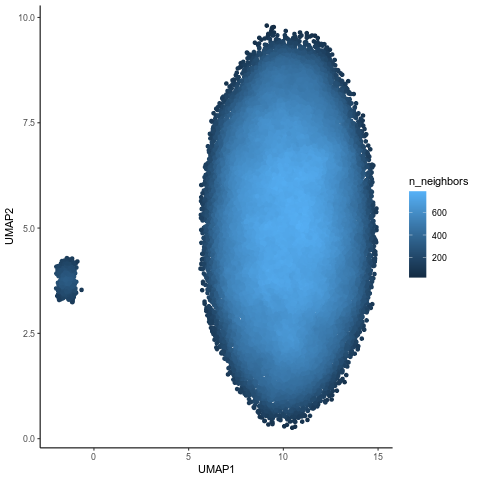

In [18]:
%%R
## density plot of cells plotted in UMAP1/UMAP2 space
library(ggplot2)
library(ggpointdensity)
library(stringr)
ggplot(UMAP_output, aes(UMAP1, UMAP2)) + geom_pointdensity() + theme_classic() +
xlab('UMAP1') + ylab('UMAP2')

In [19]:
%%R
MAVE_latent_2dims[1:5,1:5]

                              LV.mu.0      LV.mu.1           guide
miR_1:AAACCCAAGGAGAGGC-1 -0.067877077 -0.263472944 hsa-miR-203a-3p
miR_1:AAACCCAAGGTAAACT-1  0.055841550 -0.061134674   hsa-miR-93-3p
miR_1:AAACCCACAACGATCT-1 -0.039762489  0.128707662 hsa-miR-130b-3p
miR_1:AAACCCACACGATTCA-1 -0.009009097  0.012031920          TuD_NC
miR_1:AAACCCACAGTCAACT-1  0.025359716 -0.009894387 hsa-miR-147b-5p
                         hsa-miR-203a-3p hsa-miR-93-3p
miR_1:AAACCCAAGGAGAGGC-1           Guide           N/A
miR_1:AAACCCAAGGTAAACT-1             N/A         Guide
miR_1:AAACCCACAACGATCT-1             N/A           N/A
miR_1:AAACCCACACGATTCA-1             N/A           N/A
miR_1:AAACCCACAGTCAACT-1             N/A           N/A


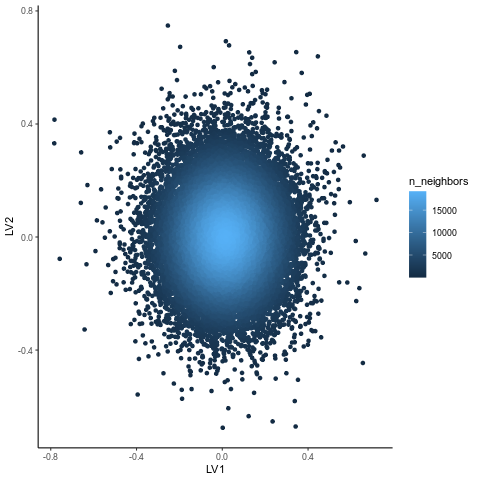

In [20]:
%%R
## density plot of cells plotted in LV.mu.0/LV.mu.1 space
library(ggplot2)
library(ggpointdensity)
library(stringr)
ggplot(MAVE_latent_2dims[,c(1,2)], aes(LV.mu.0, LV.mu.1)) + geom_pointdensity() + theme_classic() +
xlab('LV1') + ylab('LV2')


In [21]:
%%R
plts <- list()
for (i in 1:length(1:length(guides))){
    tmp <- MAVE_latent_2dims[,c(1,2,(i+3))]
    colnames(tmp)[3] <- 'Type'
    tmp <- tmp[order(tmp$Type, decreasing = TRUE),]
    if (str_sub(guides[i], start = 1, end = 6) == 'TuD_NC'){
        plts[[i]] <- ggplot(tmp, aes(LV.mu.0, LV.mu.1, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('#39568CFF', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('LV1') + ylab('LV2')
    } else {
        plts[[i]] <- ggplot(tmp, aes(LV.mu.0, LV.mu.1, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('red', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('LV1') + ylab('LV2')
    }
}


In [22]:
%%R
plts2 <- list()
for (i in 1:length(1:length(guides))){
    tmp <- UMAP_output_2dims[,c(1,2,(i+3))]
    colnames(tmp)[3] <- 'Type'
    tmp <- tmp[order(tmp$Type, decreasing = TRUE),]
    if (str_sub(guides[i], start = 1, end = 6) == 'TuD_NC'){
        plts2[[i]] <- ggplot(tmp, aes(UMAP1, UMAP2, color = Type)) + geom_point(size = 0.5) + 
        theme_classic() + scale_color_manual(values = c('#39568CFF', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('UMAP1') + ylab('UMAP2')
    } else {
        plts2[[i]] <- ggplot(tmp, aes(UMAP1, UMAP2, color = Type)) + geom_point(size = 0.5) + 
        theme_classic() + scale_color_manual(values = c('red', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('UMAP1') + ylab('UMAP2')
    }
}


In [23]:
%%R
library(ggpubr)
umap_plts <- rep(list('empty'), ceiling(length(plts2)/25))
for (i in 1:ceiling(length(plts2)/25)){
    umap_plts[[i]] <- ggarrange(plotlist = plts2[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, legend = 'none')
}

In [24]:
%%R
library(ggpubr)
latent_plts <- rep(list('empty'), ceiling(length(plts)/25))
for (i in 1:ceiling(length(plts)/25)){
    latent_plts[[i]] <- ggarrange(plotlist = plts[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, legend = 'none')
}

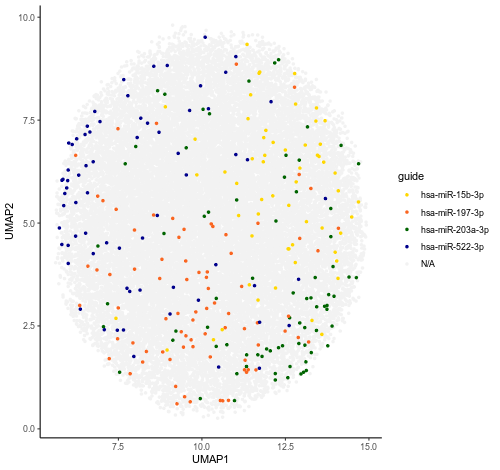

In [25]:
%%R -w 500 -h 470
## get rid of the island cells on the left
selected_guides = c('hsa-miR-203a-3p', 'hsa-miR-197-3p', 'hsa-miR-642a-5p', 'hsa-miR-522-3p', 'hsa-miR-15b-3p', 'hsa-miR-128-1-5p')
indices_selected = c(1,2,4,5)
selected_guides = selected_guides[indices_selected]
UMAP_output_select = UMAP_output
UMAP_output_select$guide = ifelse(UMAP_output$guide %in% selected_guides, UMAP_output$guide, 'N/A')
UMAP_output_select = UMAP_output_select %>% filter(UMAP1 > 0) %>% arrange(desc(factor(guide, levels = c(rev(selected_guides), 'N/A'))))
UMAP_output_select$guide = as.character(UMAP_output_select$guide)
saveRDS(UMAP_output_select, '/home/ssobti/projects/mir_tud/fig_output/data/fig2/VAE_UMAP.rds')
colors = c('hsa-miR-203a-3p' = 'darkgreen', 'hsa-miR-522-3p' = '#00008B', 'hsa-miR-15b-3p' = '#FFD700', 'hsa-miR-197-3p' = '#FA6520', 'N/A' = 'gray95')
ggplot(UMAP_output_select, aes(UMAP1, UMAP2, color = guide)) + geom_point(size = 1) + 
        theme_classic() + scale_color_manual(values = colors) + theme(plot.title = element_text(hjust = 0.5)) +
        xlab('UMAP1') + ylab('UMAP2')

In [71]:
%%R
ggsave('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/UMAP_output_select_5_x_4.7.pdf', width = 5, height = 4.7)
ggsave('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/UMAP_output_select_5.3_x_4.7.pdf', width = 5.3, height = 4.7)
ggsave('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/UMAP_output_select_5.6_x_4.7.pdf', width = 5.6, height = 4.7)
ggsave('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/UMAP_output_select_5.9_x_4.7.pdf', width = 5.9, height = 4.7)

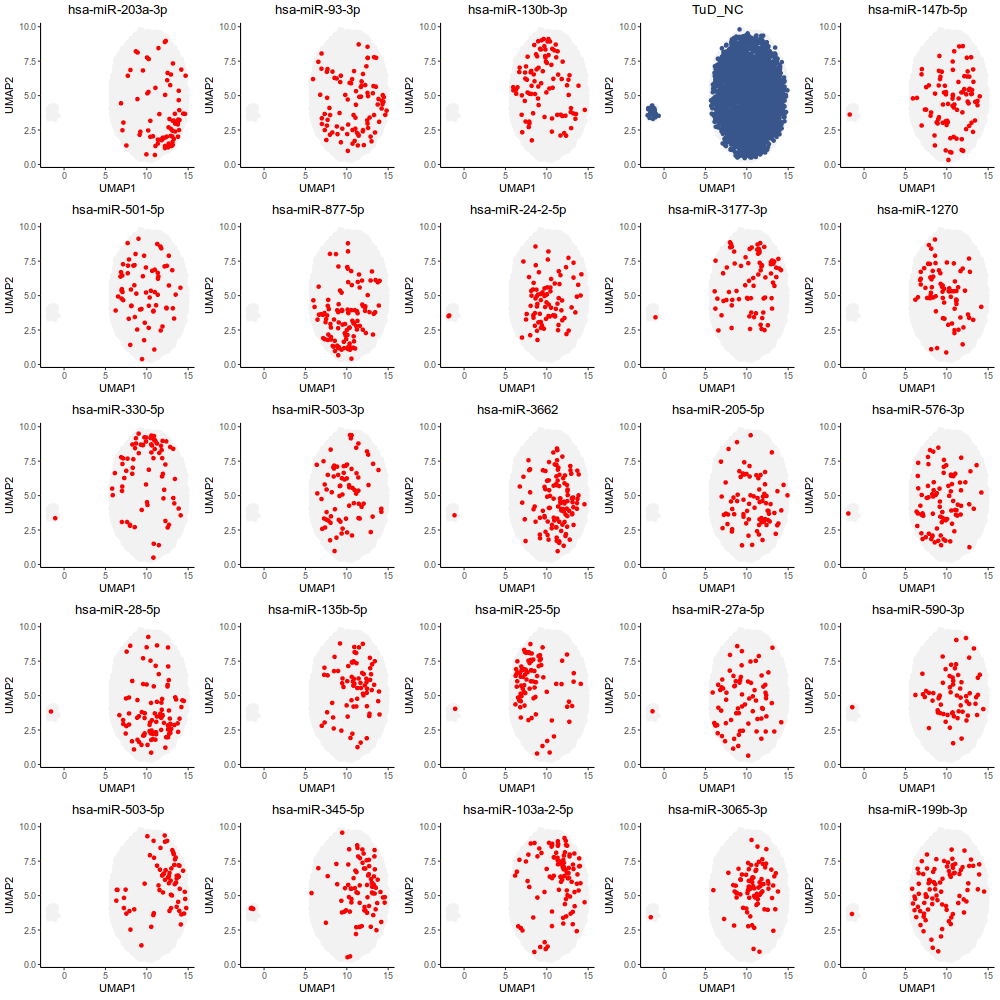

In [25]:
%%R -w 1000 -h 1000
## non-targeting control guides are blue and targeting guides are red
umap_plts[[1]]

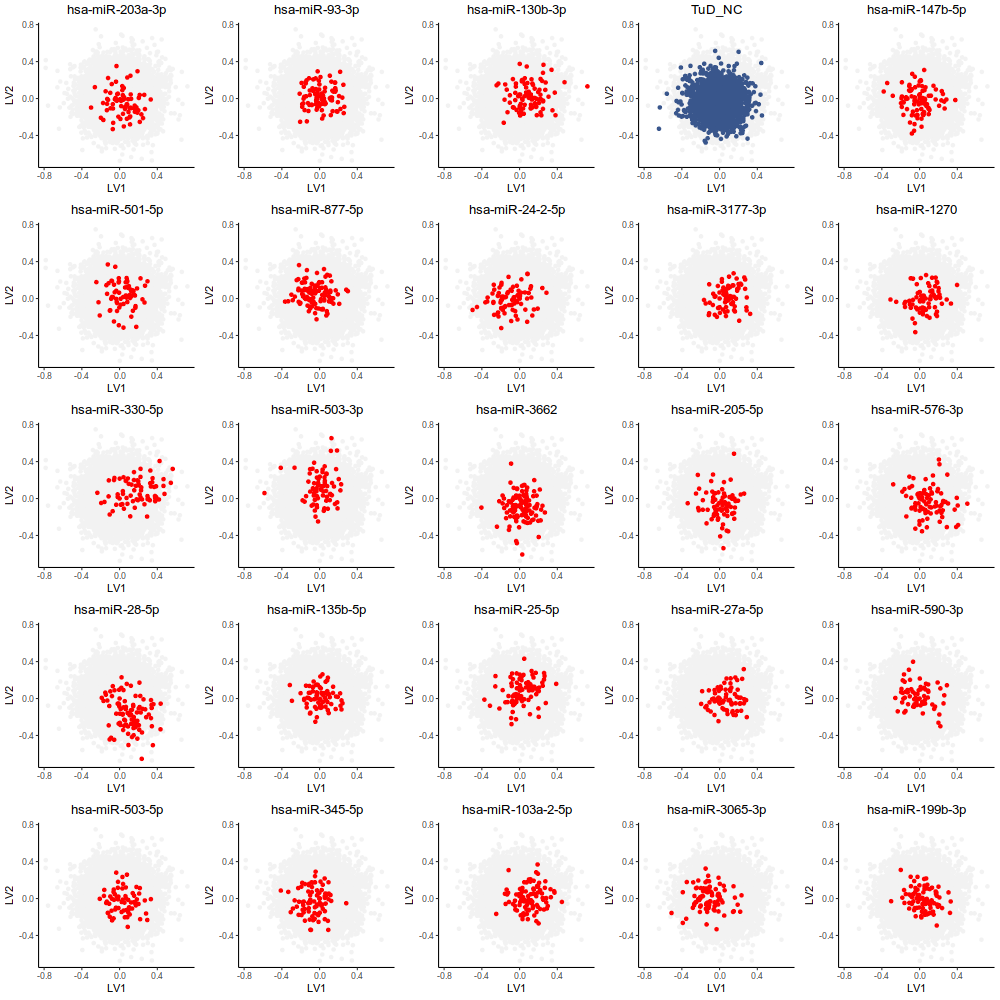

In [26]:
%%R -w 1000 -h 1000
## non-targeting control guides are blue and targeting guides are red
latent_plts[[1]]

In [27]:
%%R
## writing plots to file
pdf('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/miR_perturb_latent_maps.pdf', height = 12, width = 12)
for (i in 1:length(latent_plts)){
    print(latent_plts[[i]])
}
dev.off()

png 
  2 


In [28]:
%%R
## writing plots to file
pdf('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/miR_perturb_umaps.pdf', height = 12, width = 12)
for (i in 1:length(umap_plts)){
    print(umap_plts[[i]])
}
dev.off()

png 
  2 


In [133]:
%%R
names(plts2) = guides

In [97]:
%%R
guides_to_plot = c(
'TuD_NC',
'hsa-miR-203a-3p',
'hsa-miR-330-5p',
'hsa-miR-25-5p',
'hsa-miR-181a-2-3p',
'hsa-miR-766-3p',
'hsa-let-7b-3p',
'hsa-miR-652-3p',
'hsa-miR-3619-5p',
'hsa-miR-17-3p',
'hsa-miR-331-3p',
'hsa-miR-197-3p',
'hsa-miR-584-5p',
'hsa-miR-522-3p',
'hsa-miR-15b-3p', 'hsa-miR-642a-5p', 'hsa-miR-423-5p', 'hsa-miR-328-3p', 'hsa-miR-29c-5p', 'hsa-miR-20a-3p', 'hsa-miR-193b-3p', 'hsa-miR-1284', 'hsa-miR-132-5p', 'hsa-miR-128-1-5p')

In [134]:
%%R
plts2_adjusted = plts2

for (i in 1:length(plts2)){
    plts2_adjusted[[i]] = plts2[[i]] + theme(text = element_text(size = 8))                       
}
names(plts2_adjusted) = names(plts2)

In [135]:
%%R
filtered_umap_plots = list()
filtered_umap_plots <- rep(list('empty'), 6)
for (i in 1:6){
    filtered_umap_plots[[i]] <- ggarrange(plotlist = plts2_adjusted[guides_to_plot[(4*(i-1)+1):(4*i)]], ncol = 2, nrow = 2, legend = 'none')
}



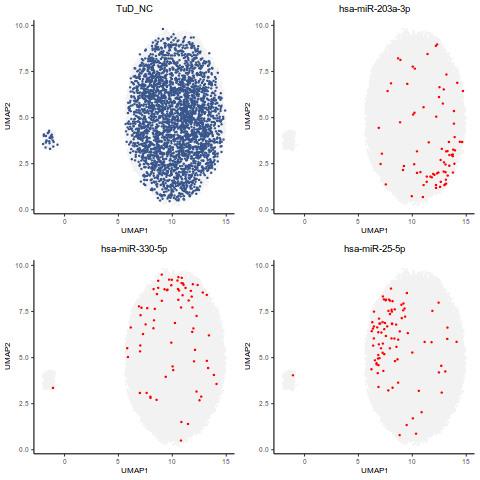

In [136]:
%%R
filtered_umap_plots[[1]]

In [141]:
%%R
filtered_umap_plots2 = ggarrange(plotlist = plts2_adjusted[guides_to_plot], ncol = 5, nrow = 5, legend = 'none')

In [129]:
%%R
filtered_umap_plots[[1]]


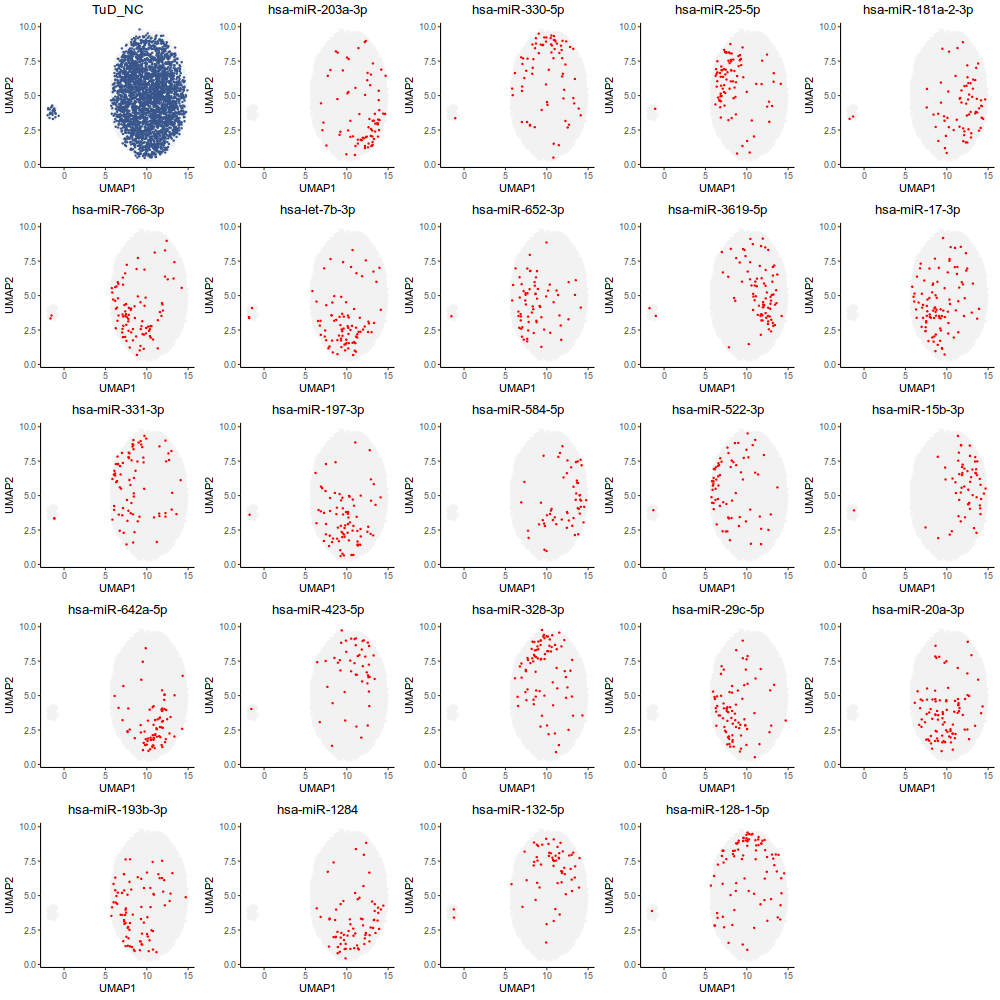

In [139]:
%%R -w 1000 -h 1000
filtered_umap_plots2

In [137]:
%%R
pdf('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/miR_perturb_umaps_filtered3.pdf', height = 6, width = 6)
for (i in 1:length(filtered_umap_plots)){
    print(filtered_umap_plots[[i]])
}
dev.off()

png 
  2 


In [142]:
%%R
pdf('/home/ssobti/projects/mir_tud/output_data/mave_output/MAVE_trial_R10000_K1_C1_T10000/miR_perturb_umaps_filtered4.pdf', height = 12, width = 12)
print(filtered_umap_plots2)
dev.off()

png 
  2 
